# Outfit Evaluation

In [ ]:
%reload_ext autoreload
%autoreload 2

In [16]:
import glob
import heapq
import json
import numpy
import os
import pickle
import random
from tqdm import tqdm
import tensorflow as tf

%pylab inline
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
import effnetv2_model

from data_process import OutfitGen

Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "disjoint" # "nondisjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"
outfit_dir = "/recsys_data/RecSys/fashion/Nordstrom/casual"

model_name = "efficientnet"
checkpoint_filepath = base_dir + "/checkpoint"
image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
data_type = "nondisjoint"
model_type = "rnn"
max_seq_len = 8
item_file = "polyvore_item_metadata.json"


In [98]:
def plot_similar_images(similar_items):
    nrows, ncols = 1, len(similar_items)
    figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))
    items = [tup[1] for tup in similar_items]
    for ii in range(ncols):
        item = items[ii]
        img = plt.imread(os.path.join(image_dir, item + ".jpg"))
        imgplot = axis[ii].imshow(img)
        axis[ii].axis('off')
    plt.show()

def plot_current_outfits(outfits, score=None, figsize=(20, 100)):
    nrows, ncols = 1, len(outfits)
    figure, axis = plt.subplots(nrows, ncols, figsize=figsize)
    for ii in range(ncols):
        im_path = outfits[ii]
        img = plt.imread(im_path)
        imgplot = axis[ii].imshow(img)
        axis[ii].axis('off')
#     if score:
#         plt.suptitle(f"Compatibility Score: {score:.2f}")
    plt.show()
    

In [14]:
with open(image_embedding_file, "rb") as fr:
    image_embedding_dict = pickle.load(fr)
print(f"Loaded {len(image_embedding_dict)} image embeddings")

Loaded 261057 image embeddings


In [18]:
eff2_model = tf.keras.models.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
                    effnetv2_model.get_model("efficientnetv2-b0", include_top=False),
                ]
            )

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


<tf.Tensor: shape=(1280,), dtype=float32, numpy=
array([-0.08912272,  0.16338086, -0.06746984, ..., -0.15146889,
       -0.16595483, -0.0618998 ], dtype=float32)>

In [19]:
all_files = [image for image in glob.glob(f"{image_dir}/*.jpg")]

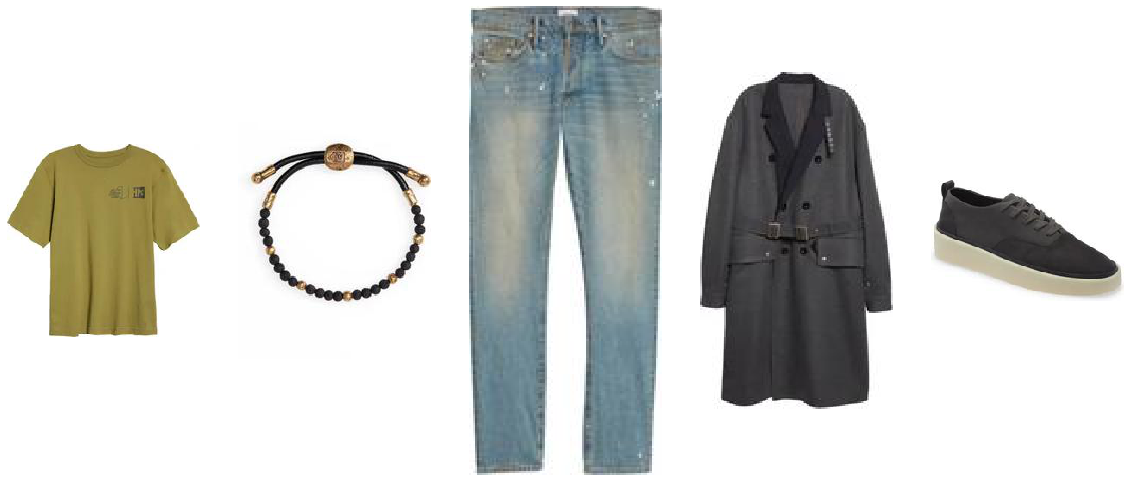

0.31260034

In [101]:
outfit_name = "weekend_casual" # "saturday_lounging" # "hanging_with_friends"
images = glob.glob(os.path.join(outfit_dir, outfit_name)+"/*.webp")
size = 224, 224
embed_dim = 1280
max_len = 8
outfit_embeddings = []
count = 0
zero_elem_image = np.zeros(embed_dim)
zeros_image = [zero_elem_image for _ in range(max_len - len(images))]
jpeg_paths = []
for img in images:
    prod_name = img.split("/")[-1].split(".")[0]
    im = Image.open(img).convert("RGB")
    w, h = im.size
    aspect = h*1.0/w
    im.thumbnail(size, Image.ANTIALIAS)
    
    jpeg_path = os.path.join(outfit_dir, outfit_name, prod_name+".jpg")
    im.save(jpeg_path, "JPEG")
    jpeg_paths.append(jpeg_path)

    image = tf.keras.preprocessing.image.load_img(jpeg_path)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    
    if aspect > 1.5:
        image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
    else:
        image_arr = tf.image.resize(image_arr, size).numpy()
    image_arr /= 255.0
    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
    outfit_embeddings.append(image_embed)
    count += 1
outfit_embeddings = np.stack(zeros_image + outfit_embeddings)
outfit_embeddings = np.expand_dims(outfit_embeddings, 0)
score = model(outfit_embeddings).numpy()[0][0]
plot_current_outfits(jpeg_paths, score)
score

In [55]:
from PIL import Image

im = Image.open(images[0]).convert("RGB")
w, h = im.size
aspect = h*1.0/w
print(im.size)
im.thumbnail(size, Image.ANTIALIAS)
# im = im.resize(size, Image.ANTIALIAS)

im.save("test.jpg", "JPEG")
im.size, aspect

(228, 370)


((138, 224), 1.6228070175438596)

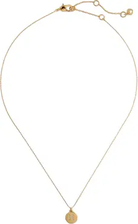

In [56]:
im

In [42]:
image = tf.keras.preprocessing.image.load_img("test.jpg")
image_arr = tf.keras.preprocessing.image.img_to_array(image)
# image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
image_arr /= 255.0
image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
image_embed.shape

TensorShape([1280])

In [43]:
q_vec = image_embed #.numpy()
image_dist = []
for image, i_vec in tqdm(image_embedding_dict.items()):
    dist = numpy.linalg.norm(q_vec - i_vec.numpy())
    heapq.heappush(image_dist, (dist, image))


100%|██████████| 261057/261057 [01:45<00:00, 2466.59it/s]


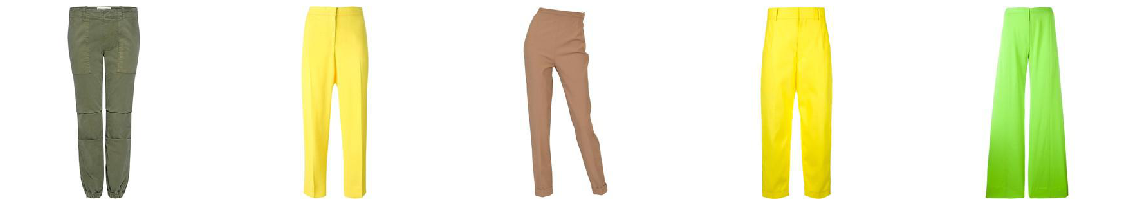

In [44]:
top_images = [heapq.heappop(image_dist) for _ in range(5)]
plot_similar_images(top_images)

In [48]:
from focal_loss import BinaryFocalLoss

model = tf.keras.models.load_model('compatibility_nondisjoint_single-transformer_model_8_only_image')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8, 1280)]         0         
_________________________________________________________________
dense_39 (Dense)             (None, 8, 64)             81984     
_________________________________________________________________
encoder_1 (Encoder)          (None, 8, 64)             130048    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 257       
Total params: 540,993
Trainable params: 540,993
Non-trainable params: 0
_________________________________________________________________
